In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from opxrd.wrapper import OpXRD
from opxrd.analysis import PlotAnalysis

test1_dirpath = '/media/daniel/mirrors/xrd.aimat.science/local/final/CNRS'
test2_dirpath = '/media/daniel/mirrors/xrd.aimat.science/local/final/HKUST'
full_dirpath = '/home/daniel/OneDrive/Downloads/opxrd_in_situ/LBNL'
d1 = OpXRD.load(dirpath=test1_dirpath)
d2 = OpXRD.load(dirpath=test2_dirpath)

analyser = PlotAnalysis(databases=[d1], output_dirpath='/tmp/opxrd_analysis')

2025-04-24 13:27:57,770 - INFO - Loading patterns from local dirpath /media/daniel/mirrors/xrd.aimat.science/local/final/CNRS
100% (1058 of 1058) |####################| Elapsed Time: 0:00:05 Time:  0:00:050000
2025-04-24 13:28:03,373 - INFO - Finished loading pattern database located at /media/daniel/mirrors/xrd.aimat.science/local/final/CNRS
2025-04-24 13:28:03,374 - INFO - Successfully extracted 1058 patterns from 1058/1058 xrd files
2025-04-24 13:28:03,376 - INFO - Loading patterns from local dirpath /media/daniel/mirrors/xrd.aimat.science/local/final/HKUST
100% (520 of 520) |######################| Elapsed Time: 0:00:01 Time:  0:00:010000
2025-04-24 13:28:04,739 - INFO - Finished loading pattern database located at /media/daniel/mirrors/xrd.aimat.science/local/final/HKUST
2025-04-24 13:28:04,740 - INFO - Successfully extracted 520 patterns from 520/520 xrd files


---> Combined pattern plot for databaes ['a:CNRS'] | No. patterns = 50

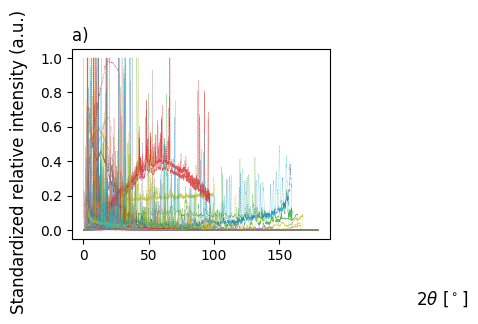

In [18]:
analyser.plot_in_single(limit_patterns=50)

---> Cumulative explained variance ratio $v$ over components |  $v =  \frac{\sum_i \lambda_i}{\sum^n_{j=1} \lambda_j}$

/home/daniel/aimat/opxrd/opxrd/analysis/plot.py:162: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right', ncols=2, fontsize='small')


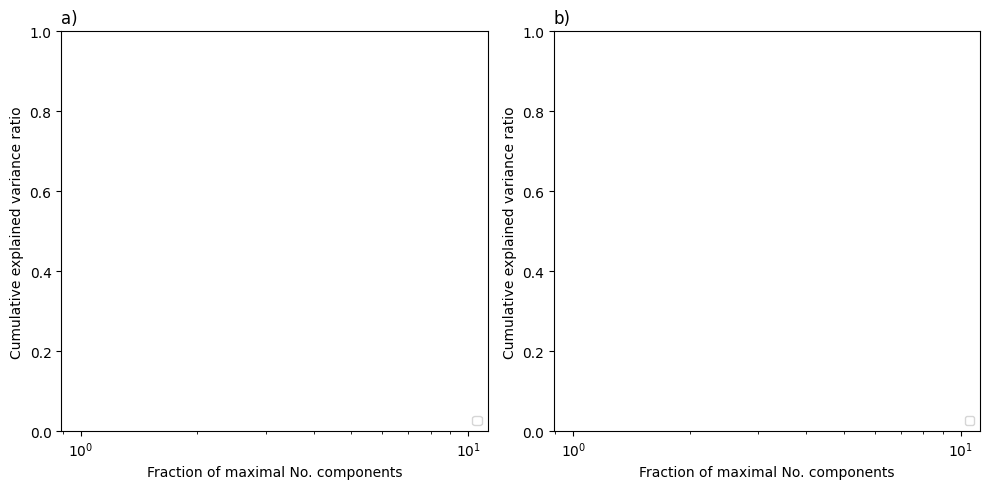

---> Cumulative explained variance ratio $v$ over components |  $v =  \frac{\sum_i \lambda_i}{\sum^n_{j=1} \lambda_j}$

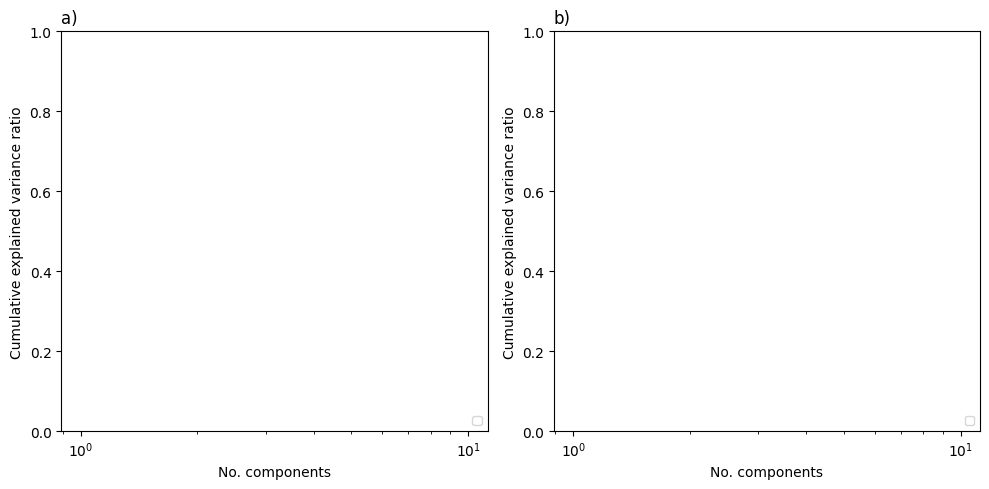

In [19]:
analyser.plot_effective_components()
analyser.plot_effective_components(use_fractions=False)

---> Histograms detailing properties of all patterns in the opXRD database: a) distribution of angular resolu-tion in all data; b) distribution of smallest and largest recorded 2θ values for all data.

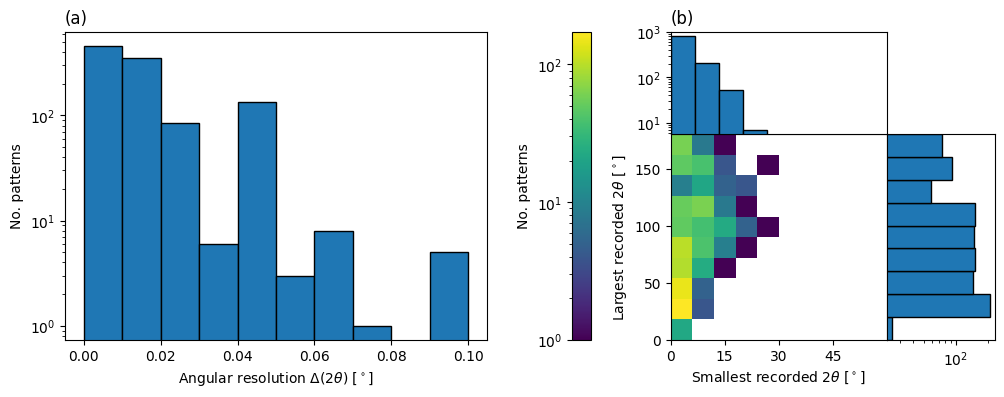

In [20]:
analyser.xrd_histogram()

---> Histograms detailing properties of labeled patterns in the opXRD database: a) distribution of elements occuring in samples;b) distribution of spacegroups; c) distribution of No. atoms N_{\text{atom}}; d) distribution of unit cell volume V_{\text{uc}}

<string>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


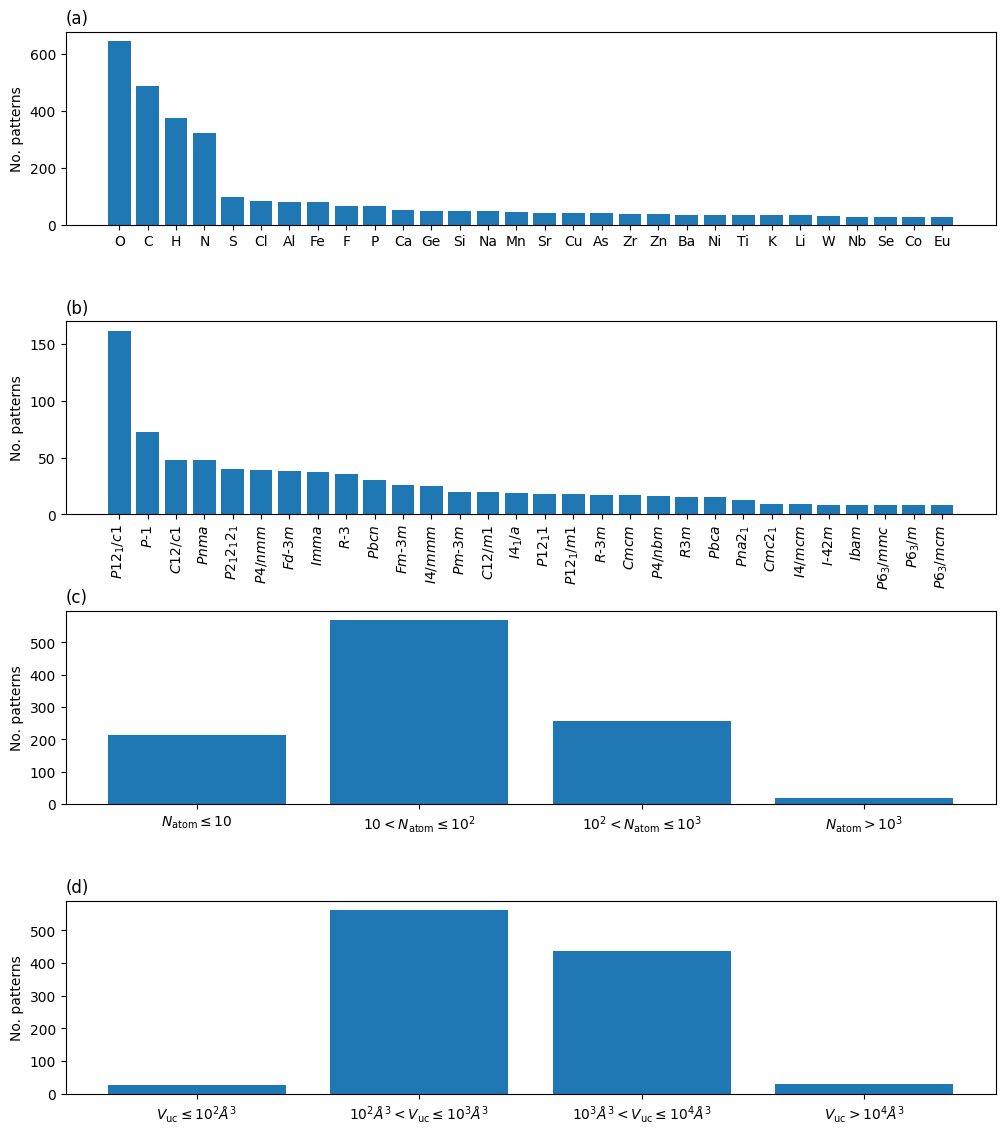

In [21]:
analyser.print_text(f'---> Histograms detailing properties of labeled patterns in the opXRD database: '
                    f'a) distribution of elements occuring in samples;'
                    r'b) distribution of spacegroups; c) distribution of No. atoms N_{\text{atom}}; '
                    r'd) distribution of unit cell volume V_{\text{uc}}')
analyser.structure_histogram()